In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import os
from visualisation import plot_TORQUE
from label import *
from datetime import timedelta
from evaluation import *

In [2]:
EFS_PATH = Path('/home/ec2-user/SageMaker/efs/')
data_from_folder='brett_extract_from_s3'
output_save_folder='att2_new_extracts'

In [3]:
label_df = pd.read_csv(EFS_PATH/"data/All_Roma_Flush_Fail_PCP_Change_w_comment.csv")
label_df.dropna(subset = "Event Date", inplace=True)
label_df['Event Date'] = pd.to_datetime(label_df['Event Date'])
label_df.set_index("Event Date",inplace=True)

## Find valid wells.
Valid wells are those whose data were downloaded, and whose labels are within the recorded time period in the csv files

In [4]:
file_list = os.listdir(EFS_PATH/'data'/data_from_folder)
file_list = list(filter(lambda x: '.pkl' in x, file_list))
S3_well_list = {x.split("_tag_")[1].split(".pkl")[0] for x in file_list}
labelled_well_list = set(label_df.WellCD.values)
intersection_list = S3_well_list.intersection(labelled_well_list)

In [5]:
to_remove = set()
for well_id in intersection_list:
    tag_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/data/{data_from_folder}/limited_tag_{well_id}.pkl')
    start=str(tag_df.index.min().date())
    end=str(tag_df.index.max().date())
    label = label_df[label_df.WellCD==well_id]
    label = label.sort_index().loc[start:end,:]
    if len(label)==0:
        print(f"{well_id} non-overlapping timestamp.")
        to_remove.add(well_id)
    

RM02-55-1 non-overlapping timestamp.
RM02-56-1 non-overlapping timestamp.
RM02-58-1 non-overlapping timestamp.
RM02-28-1 non-overlapping timestamp.
RM02-10-1 non-overlapping timestamp.
RM03-01-1 non-overlapping timestamp.
RM02-04-1 non-overlapping timestamp.


In [6]:
well_list = intersection_list - to_remove

# Determine well type

In [7]:
motor_set = set()
rod_set = set()

for well_id in well_list:
    tag_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/data/{data_from_folder}/limited_tag_{well_id}.pkl')
    total_na_motor = tag_df['TORQUE_MOTOR'].isna().sum()
    if total_na_motor == len(tag_df):
        rod_set.add(well_id)
    else:
        motor_set.add(well_id)
    

In [8]:
rod_set

{'RM01-12-1',
 'RM01-16-1',
 'RM02-29-2',
 'RM02-36-3',
 'RM02-52-1',
 'RM03-02-1',
 'RM03-03-1',
 'RM03-08-1',
 'RM03-09-1',
 'RM03-15-1',
 'RM03-17-1',
 'RM03-39-1',
 'RM03-52-1',
 'RM03-62-1',
 'RM03-63-1',
 'RM03-76-1',
 'RM03-79-1',
 'RM03-86-1',
 'RM03-87-1',
 'RM03-98-1',
 'RM07-10-2',
 'RM07-24-1',
 'RM07-95-1',
 'RM50-17-1'}

# Call Brett's method to label data

In [ ]:
%%timeit
for well_id in rod_set:
    spike_label_df, ramp_label_df = generate_labels(well_id=well_id, 
                        feat='TORQUE_ROD', 
                        speed_feat='SPEED_ROD',
                        polynomial_days='7d', 
                        polynomial_degree=4, 
                        off_threshold=10, 
                        flush_diff_threshold=4.9, 
                        flush_std_threshold=4, 
                        spike_diff_threshold=0.021,
                        diff_compare_window=60,
                        ramp_integral_threshold=0.7)

RM01-12-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-39-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-63-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-17-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-15-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-52-1
off trace done
flush trace done
poly fit done
ramping alert done
RM02-52-1
off trace done
flush trace done
poly fit done
ramping alert done
RM07-95-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-62-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-79-1
off trace done
flush trace done
poly fit done
ramping alert done
RM07-10-2
off trace done
flush trace done
poly fit done
ramping alert done
RM03-86-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-02-1
off trace done
flush trace done
poly fit done
ramping alert done
RM03-08-1
off trace done


In [18]:
well_id = 'RM07-24-1'
tag_df, ramp_df, spike_df, label, min_date, max_date = get_data(well_id,label_df)

In [19]:
label

,Well Name,WellCD,Event,Reactive_Result,Well Failure Number,Counted_As_Failure,Failure Mode,Root Cause,AT_FlushVolume_L,Time_Max_RPM_Hrs,Flush_RPM,Flush_Comment,comments
Event Date,,,,,,,,,,,,,
2020-05-15,RM07-24-1,RM07-24-1,Rig Intervention,NaN,1.0,1.0,Inconclusive,Unknown,NaN,NaN,NaN,NaN,NaN
2020-05-15,RM07-24-1,RM07-24-1,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_31034/2379143249.py:143: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/high-torque/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



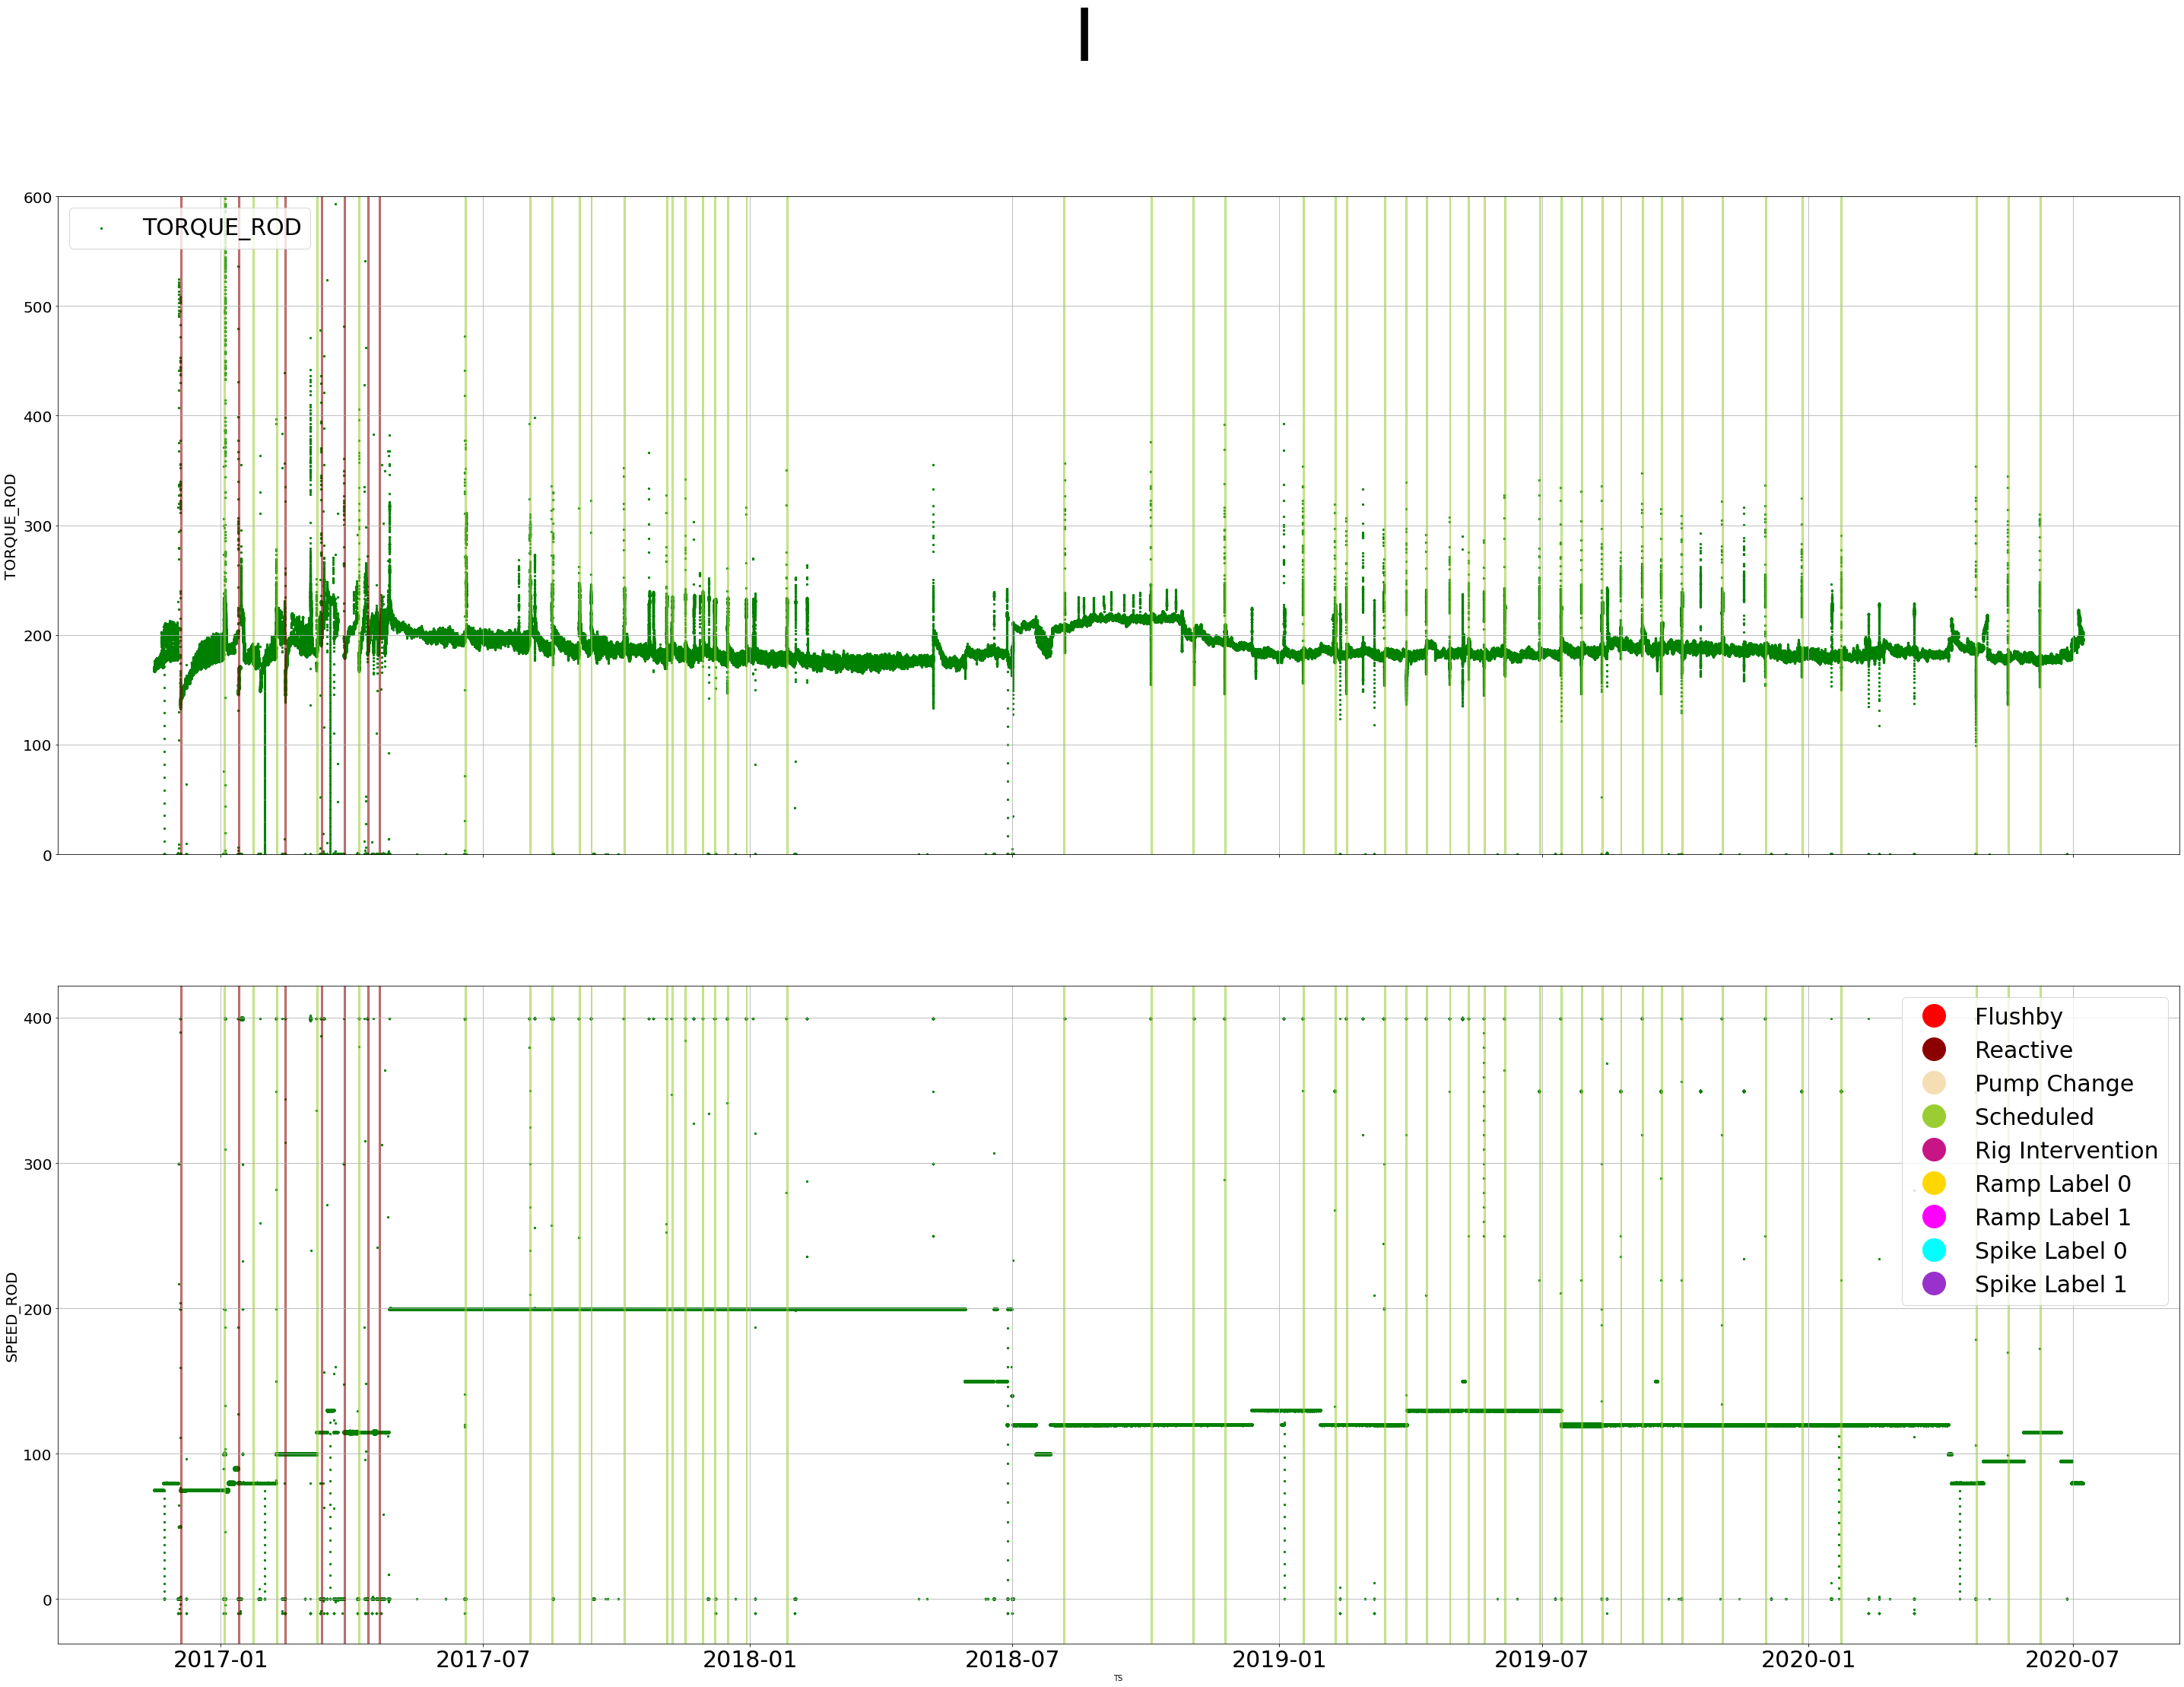

In [13]:
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = None,
                  spike_label = None,
                  label_df=label,
                  start=min_date,
                  end=max_date,
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]})

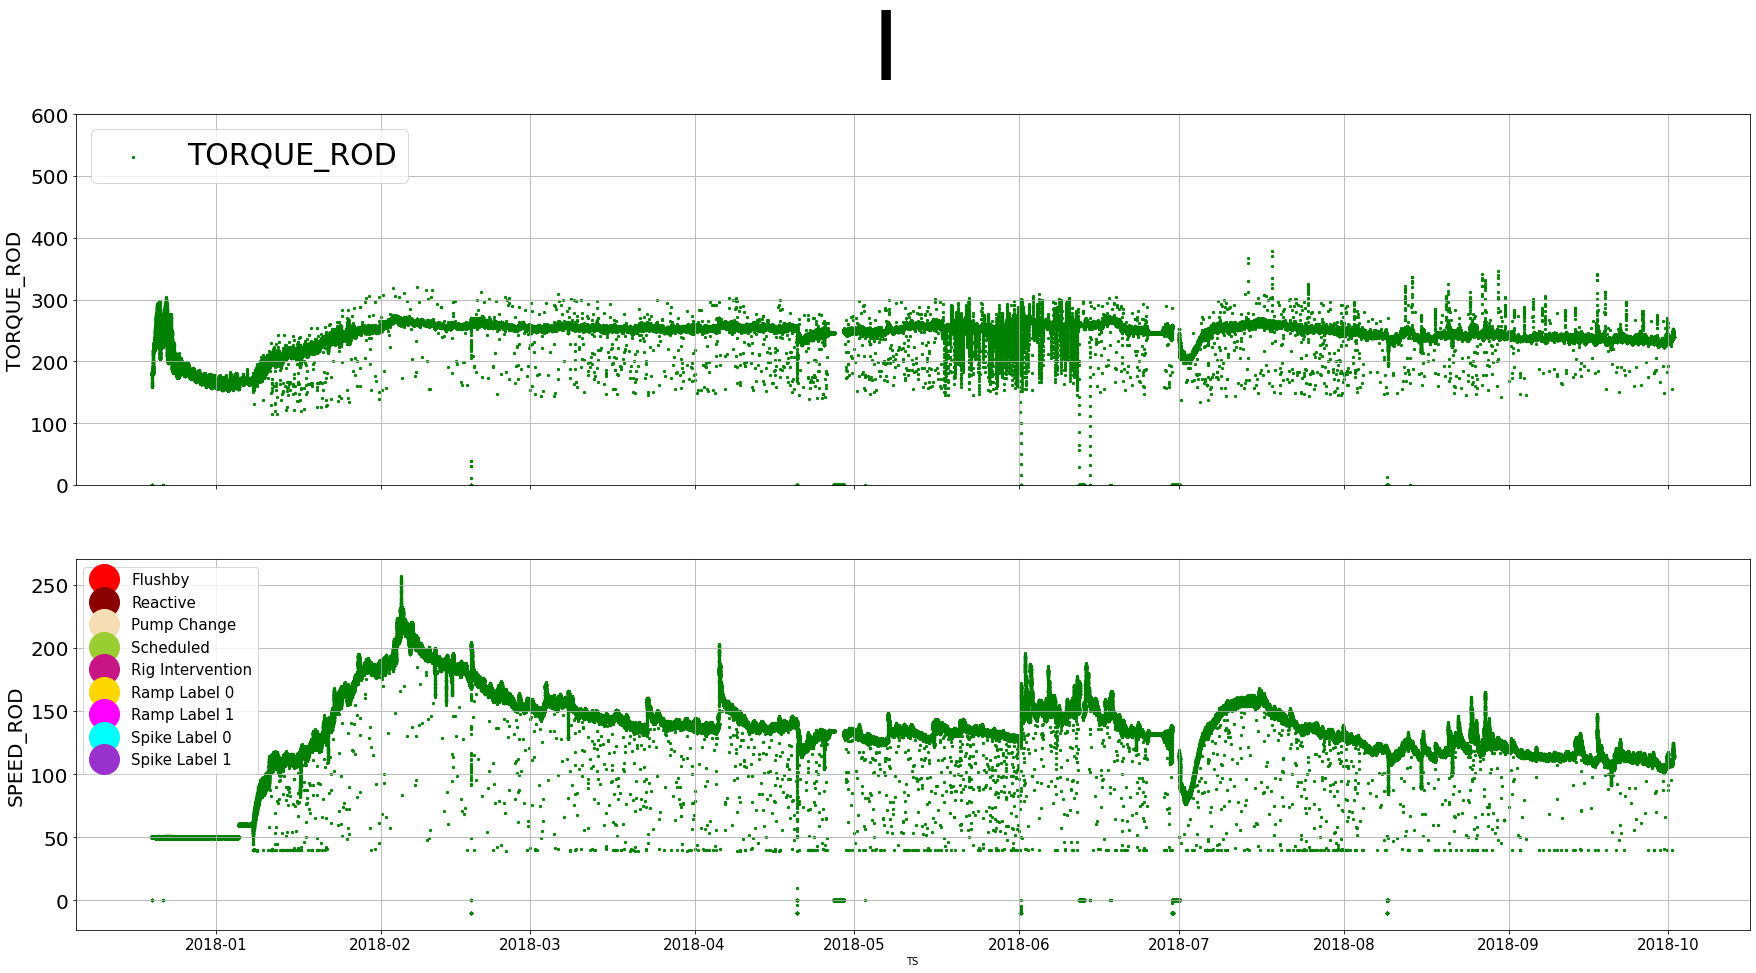

In [74]:
well_id = 'RM07-95-1'
tag_df, ramp_df, spike_df, label =  get_data(well_id, label_df = label_df)

fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = ramp_df,
                  spike_label = None,
                  label_df=label_df,
                  start='2017-01-01',
                  end='2018-10-01',
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]})

In [73]:
tag_df

,Unnamed: 0,TORQUE_MOTOR,TORQUE_ROD,SPEED_MOTOR,SPEED_ROD,EFFICIENCY_PUMP,LEVEL_DOWNHOLE,FLOW_GAS,FLOW_WATER,TEMP_GAS,PRESSURE_AN,PRESSURE_DH,PRESSURE_GAS,PRESSURE_TUB,PRESSURE_WATER
TS,,,,,,,,,,,,,,,
2017-12-19 23:21:50.239,0,NaN,165.479980,49.699997,50.199997,NaN,NaN,43.680000,NaN,NaN,185.0,2531.0,NaN,NaN,NaN
2017-12-19 23:22:50.239,0,NaN,165.479980,49.699997,50.199997,NaN,NaN,43.680000,NaN,NaN,185.0,2531.0,NaN,NaN,NaN
2017-12-19 23:23:50.239,1,NaN,164.500000,54.899994,50.178568,NaN,NaN,45.360001,NaN,NaN,149.0,2511.0,154.0,NaN,NaN
2017-12-19 23:24:50.239,2,NaN,159.269989,62.500000,50.157139,NaN,NaN,39.360001,NaN,NaN,143.0,2508.0,150.0,0.0,139.0
2017-12-19 23:25:50.239,3,NaN,159.499987,59.199997,50.135711,NaN,NaN,49.632000,0.0,28.099998,152.0,2540.0,159.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 23:55:50.239,28579,NaN,-0.010000,0.000000,0.000000,NaN,NaN,4.032000,0.0,21.500000,134.0,0.0,147.0,91.0,101.0
2022-07-31 23:56:50.239,28580,NaN,-0.010000,0.000000,0.000000,NaN,NaN,3.960000,0.0,21.500000,133.0,0.0,147.0,90.0,101.0
2022-07-31 23:57:50.239,28581,NaN,-0.010000,0.000000,0.000000,NaN,NaN,4.152000,0.0,21.500000,134.0,0.0,147.0,92.0,101.0


In [70]:
metrics_set = []
for well_id in rod_set:
    print(f"Processing {well_id}")
    metrics_raw = evaluate_model(well_id,label_df)
    if metrics_raw is not None:
        metrics = pd.DataFrame(metrics_raw).T
        metrics.index = [well_id+"_"+k for k in metrics.index]
        metrics_set.append(metrics)
metrics = pd.concat(metrics_set,axis=0)

Processing RM01-12-1
Processing RM03-39-1
Processing RM03-63-1
Processing RM03-17-1
Processing RM03-15-1
Processing RM03-52-1
Processing RM02-52-1
Processing RM07-95-1
Processing RM03-62-1
Processing RM03-79-1
Processing RM07-10-2
Processing RM03-86-1
Processing RM03-02-1
Processing RM03-08-1
Processing RM03-76-1
division by zero
TPn+FNn=0
division by zero
TPn+FNn=0
division by zero
TPn+FNn=0
division by zero
TPn+FNn=0
Processing RM03-09-1
Processing RM50-17-1
Processing RM01-16-1
Processing RM03-87-1
Processing RM02-36-3
Processing RM07-24-1
Processing RM02-29-2
Processing RM03-03-1
Processing RM03-98-1


In [71]:
metrics = pd.concat(metrics_set,axis=0)
metrics.to_csv("Prediction_Metrics.csv")

In [68]:
import pandas as pd 
import numpy as np 
from pathlib import Path
from datetime import timedelta 

EFS_PATH = Path('/home/ec2-user/SageMaker/efs/')
data_from_folder='brett_extract_from_s3'
output_save_folder='att2_new_extracts'

def get_data(well_id, label_df=None, buffer_days=30):
    tag_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/data/{data_from_folder}/limited_tag_{well_id}.pkl')
    tag_df=tag_df.asfreq('T', method='ffill')#.resample('1min').mean()#
    tag_df=tag_df.interpolate(method='linear', axis=0)

    ramp_df = pd.read_pickle(f'/home/ec2-user/SageMaker/efs/labels/{output_save_folder}/ramping_alert_df{well_id}.pkl')
    ramp_df = ramp_df[ramp_df.ramp_label==1]
    spike_df = pd.read_pickle(f'/home/ec2-user/SageMaker/efs/labels/{output_save_folder}/1hrtorque_spike_label_{well_id}.pkl')
    spike_df = spike_df[spike_df.spike_label==1]
    label = label_df[label_df.WellCD==well_id].sort_index()

    return tag_df,ramp_df, spike_df, label

def get_cm_statistic(pred_df, tag_df, label, feature='TORQUE_ROD', off_threshold=10, pseudo_threshold=0.20):
    #Get positive ground truths
    min_date = tag_df.index.min().date()
    min_tag_date = pd.Timestamp(min_date)
    max_tag_date = pd.Timestamp(tag_df.index.max().date() - timedelta(days=1))
    max_date = label.index.max().date()
    all_negatives = np.unique(pd.date_range(min_date, max_date, freq='D').date)
    positive_preds = np.unique(pred_df.index.date)
    negative_preds = np.setdiff1d(all_negatives, positive_preds)
    positive_gt_ = label[label.Event!="Scheduled"].index.unique()
    positive_gt = np.unique([pd.date_range(x-timedelta(days=30),x).date for x in positive_gt_])

    #For a buffer period of 30 days after an event occurs, 
    #if the torque is 0 for 10% of the time and if any label is issued in that 30 day period -> the label is not a false positive 
    #Exception to the rule: if both the torque and speed are non-zero for 7 days after the last 0 and label is issued -> label is a false positive
    for positive_date in positive_gt_:
        if (positive_date > max_tag_date) or (positive_date < min_tag_date):
            continue
        valid_upper_range = min(positive_date+timedelta(days=30), max_tag_date)
        buffer_period = pd.date_range(positive_date,valid_upper_range).date
        data = tag_df.loc[buffer_period.min():buffer_period.max(), feature]
        thresholded_data = data[data<=off_threshold]
        last_day = thresholded_data.index.max()
        ratio = len(thresholded_data)/len(data)
        if ratio >= pseudo_threshold:
            positive_gt = np.union1d(positive_gt, pd.date_range(positive_date,last_day).date)

    negative_gt = np.setdiff1d(all_negatives, positive_gt_)
    check_positive = np.vectorize(lambda x: x in positive_gt)
    check_negative = np.vectorize(lambda x: x in negative_gt)
    #TP is number of positives being picked up 
    TP = positive_preds[check_positive(positive_preds)]
    FP = np.setdiff1d(positive_preds,TP)
    TN = negative_preds[check_negative(negative_preds)]
    FN = np.setdiff1d(negative_preds,TN)

    TPn = len(TP)
    FPn = len(FP)
    TNn = len(TN)
    FNn = len(FN)
    try:
        TPR = TPn/(TPn+FNn) 
    except Exception as e:
        TPR = -1
        print(e)
        print("TPn+FNn=0")
        
    try:
        FPR = FPn/(FPn+TNn)
    except Exception as e:
        FPR = -1
        print(e)
        print("FPn+NNn=0")
        
    try:
        TNR = TNn/(TNn+FPn)
    except Exception as e:
        TNR = -1
        print(e)
        print("FPn+TNn=0")
    
    try:
        FNR = FNn/(TPn+FNn)
    except Exception as e:
        FNR = -1
        print(e)
        print("TPn+FNn=0")
        
    return TPn, FPn, TNn, FNn, TPR, FPR, TNR, FNR, TP, FP, TN, FN

def evaluate_model(well_id, label_df,buffer_days=30,feature='TORQUE_ROD',off_threshold=10,pseudo_threshold=0.1):
    tag_df,ramp_df, spike_df, label= get_data(well_id, label_df=label_df, buffer_days=buffer_days)
    if len(tag_df)==0:
        print(f"Empty tag df for well: {well_id}")
        return None
    if len(label)==0:
        print(f"Empty label for well: {well_id}")
        return None
    metrics = {mode:{'TP':0,'FP':0,'TN':0,'FN':0,'TPR':0,'FPR':0,'TNR':0,'FNR':0} for mode in ['ramp','spike']}
    #Evaluate Ramp only
    for mode in ['ramp','spike']:
        if mode == 'ramp':
            pred_df = ramp_df
        if mode == 'spike':
            pred_df = spike_df
        else:
            pred_df = pd.concat([ramp_df,spike_df],axis=0)
        TP,FP,TN,FN,TPR,FPR,TNR,FNR,_,_,_,_= get_cm_statistic(pred_df,tag_df,label,feature=feature,off_threshold=off_threshold,pseudo_threshold=pseudo_threshold)
        metrics[mode]['TP'] = TP
        metrics[mode]['TPR'] = TPR
        metrics[mode]['TN'] = TN
        metrics[mode]['TNR'] = TNR
        metrics[mode]['FP'] = FP
        metrics[mode]['FPR'] = FPR
        metrics[mode]['FN'] = FN
        metrics[mode]['FNR'] = FNR
    return metrics

In [69]:
evaluate_model('RM50-17-1',label_df)

{'ramp': {'TP': 192,
  'FP': 329,
  'TN': 809,
  'FN': 0,
  'TPR': 1.0,
  'FPR': 0.28910369068541303,
  'TNR': 0.710896309314587,
  'FNR': 0.0},
 'spike': {'TP': 151,
  'FP': 227,
  'TN': 952,
  'FN': 0,
  'TPR': 1.0,
  'FPR': 0.19253604749787956,
  'TNR': 0.8074639525021204,
  'FNR': 0.0}}

In [30]:
feature = 'TORQUE_ROD'
off_threshold = 10
pseudo_threshold=0.05

well_id = 'RM02-29-2'
tag_df, ramp_df, spike_df, label, min_date, max_date = get_data(well_id)
pred_df = ramp_df
all_negatives = np.unique(pd.date_range(min_date, max_date, freq='D').date)
positive_preds = np.unique(pred_df.index.date)
negative_preds = np.setdiff1d(all_negatives, positive_preds)
positive_gt_ = label[label.Event!="Scheduled"].index.unique()
positive_gt = np.unique([pd.date_range(x-timedelta(days=30),x).date for x in positive_gt_])

for positive_date in positive_gt_:
    buffer_period = pd.date_range(positive_date,positive_date+timedelta(days=30)).date
    data = tag_df.loc[buffer_period.min():buffer_period.max(), feature].values
    thresholded_data = data[data<=off_threshold]
    ratio = len(thresholded_data)/len(data)
    if ratio >= pseudo_threshold:
        positive_gt = np.union1d(positive_gt, buffer_period)

negative_gt = np.setdiff1d(all_negatives, positive_gt_)
check_positive = np.vectorize(lambda x: x in positive_gt)
check_negative = np.vectorize(lambda x: x in negative_gt)
#TP is number of positives being picked up 
TP = positive_preds[check_positive(positive_preds)]
FP = np.setdiff1d(positive_preds,TP)
TN = negative_preds[check_negative(negative_preds)]
FN = np.setdiff1d(negative_preds,TN)

TPn = len(TP)
FPn = len(FP)
TNn = len(TN)
FNn = len(FN)
TPR = TPn/(TPn+FNn) 
FPR = FPn/(FPn+TNn)
TNR = TNn/(TNn+FPn)
FNR = FNn/(TPn+FNn)

In [31]:
label

,Well Name,WellCD,Event,Reactive_Result,Well Failure Number,Counted_As_Failure,Failure Mode,Root Cause,AT_FlushVolume_L,Time_Max_RPM_Hrs,Flush_RPM,Flush_Comment,comments
Event Date,,,,,,,,,,,,,
2017-05-22,RM02-29-2,RM02-29-2,Rig Intervention,NaN,1.0,1.0,Hole in Tubing,Solids Transport (Tubing),NaN,NaN,NaN,NaN,NaN
2017-06-15,RM02-29-2,RM02-29-2,Rig Intervention,NaN,2.0,1.0,Plugged Discharge,Solids Transport (Tubing),NaN,NaN,NaN,NaN,NaN
2017-06-15,RM02-29-2,RM02-29-2,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-17,RM02-29-2,RM02-29-2,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-18,RM02-29-2,RM02-29-2,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-27,RM02-29-2,RM02-29-2,Flushby,NaN,3.0,NaN,Plugged Discharge,Solids Transport (Tubing),NaN,NaN,NaN,NaN,NaN
2017-09-29,RM02-29-2,RM02-29-2,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-16,RM02-29-2,RM02-29-2,Rig Intervention,NaN,4.0,1.0,Plugged Discharge,Solids Transport (Tubing),NaN,NaN,NaN,NaN,NaN
2017-10-16,RM02-29-2,RM02-29-2,Reactive,Unsuccessful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


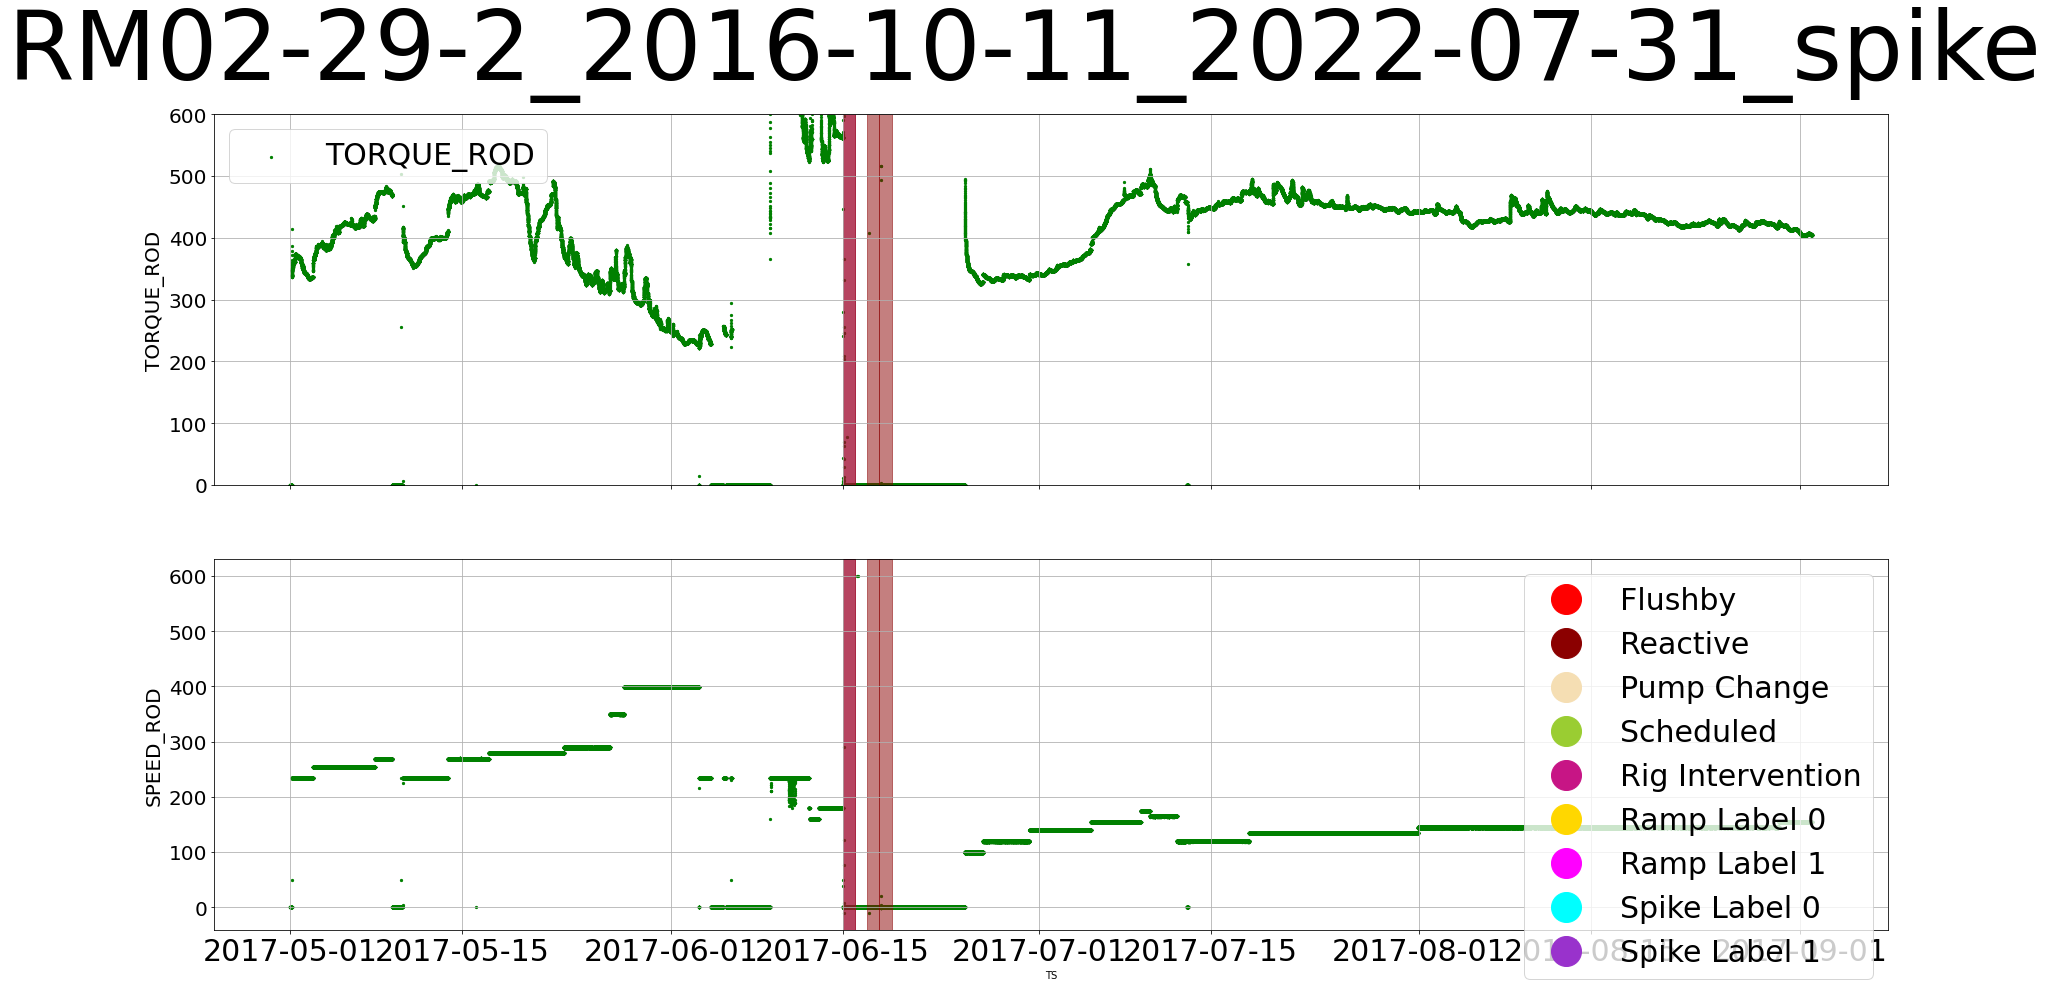

In [36]:
label_data = 'spike'
save_name = f"{well_id}_{start}_{end}_{label_data}.png"

if label_data == 'ramp':
    ramp_label = ramp_df
    spike_label = None
if label_data == 'spike':
    ramp_label = None
    spike_label = spike_df
if label_data == 'both':
    ramp_label = ramp_df
    spike_label = spike_df 
    
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = None,
                  spike_label = None,
                  label_df=changed_label,
                  start='2017-05-01',
                  end='2017-09-01',
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]},
                  save_name=save_name)

In [35]:
changed_label = label.drop("2017-05-22")

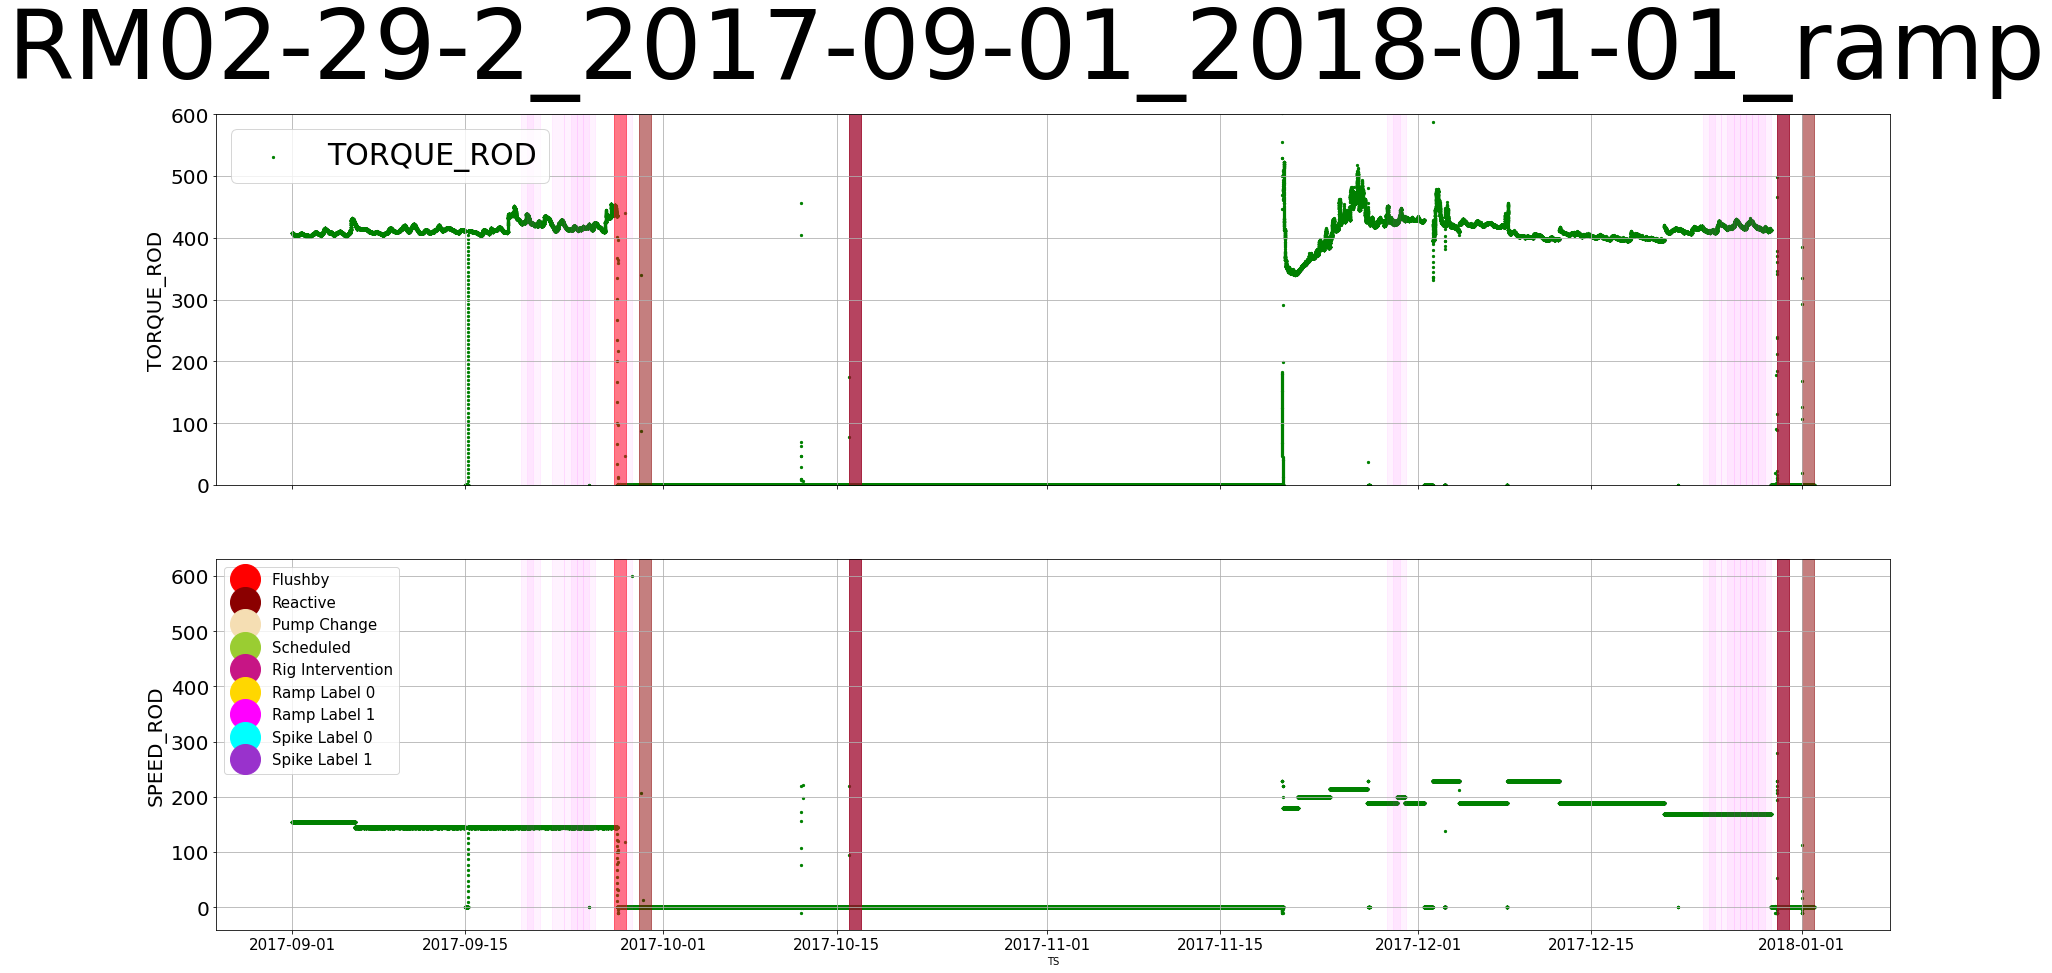

In [49]:
label_data = 'ramp'
start = '2017-09-01'
end = '2018-01-01'
save_name = f"{well_id}_{start}_{end}_{label_data}.png"

if label_data == 'ramp':
    ramp_label = ramp_df
    spike_label = None
if label_data == 'spike':
    ramp_label = None
    spike_label = spike_df
if label_data == 'both':
    ramp_label = ramp_df
    spike_label = spike_df 
    
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = ramp_label,
                  spike_label = None,
                  label_df=changed_label,
                  start=start,
                  end=end,
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]},
                  save_name=save_name)

In [70]:
well_id = 'RM03-87-1'
tag_df, ramp_df, spike_df, label, min_date, max_date = get_data(well_id)

In [77]:
all_label_df = pd.concat([spike_df, ramp_df])
all_label_df = all_label_df.reset_index()

In [81]:
all_label_df

,TS,spike_label,ramp_label
0,11/21/2016 20:43:33,1,NaN
1,11/21/2016 20:44:33,1,NaN
2,11/21/2016 20:45:33,1,NaN
3,11/21/2016 20:46:33,1,NaN
4,11/21/2016 20:49:33,1,NaN
...,...,...,...
3779,07/04/2020 23:59:33,NaN,1.0
3780,07/05/2020 11:59:33,NaN,1.0
3781,07/05/2020 23:59:33,NaN,1.0
3782,07/06/2020 11:59:33,NaN,1.0


In [80]:
all_label_df.TS = all_label_df.TS.apply(lambda x: x.strftime("%m/%d/%Y %H:%M:%S"))

In [82]:
all_label_df.to_csv("RM03-87-1_model_label.csv",index=False)

In [83]:
label

,Well Name,WellCD,Event,Reactive_Result,Well Failure Number,Counted_As_Failure,Failure Mode,Root Cause,AT_FlushVolume_L,Time_Max_RPM_Hrs,Flush_RPM,Flush_Comment,comments
Event Date,,,,,,,,,,,,,
2016-12-04,COXON CREEK 8,RM03-87-1,Reactive,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,COXON CREEK 8,RM03-87-1,Scheduled,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN
2017-01-13,COXON CREEK 8,RM03-87-1,Reactive,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-23,COXON CREEK 8,RM03-87-1,Scheduled,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN
2017-02-08,COXON CREEK 8,RM03-87-1,Scheduled,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN
2017-02-14,COXON CREEK 8,RM03-87-1,Reactive,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08,COXON CREEK 8,RM03-87-1,Scheduled,NaN,NaN,NaN,NaN,NaN,7000.0,NaN,NaN,NaN,NaN
2017-03-11,COXON CREEK 8,RM03-87-1,Reactive,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-27,COXON CREEK 8,RM03-87-1,Reactive,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


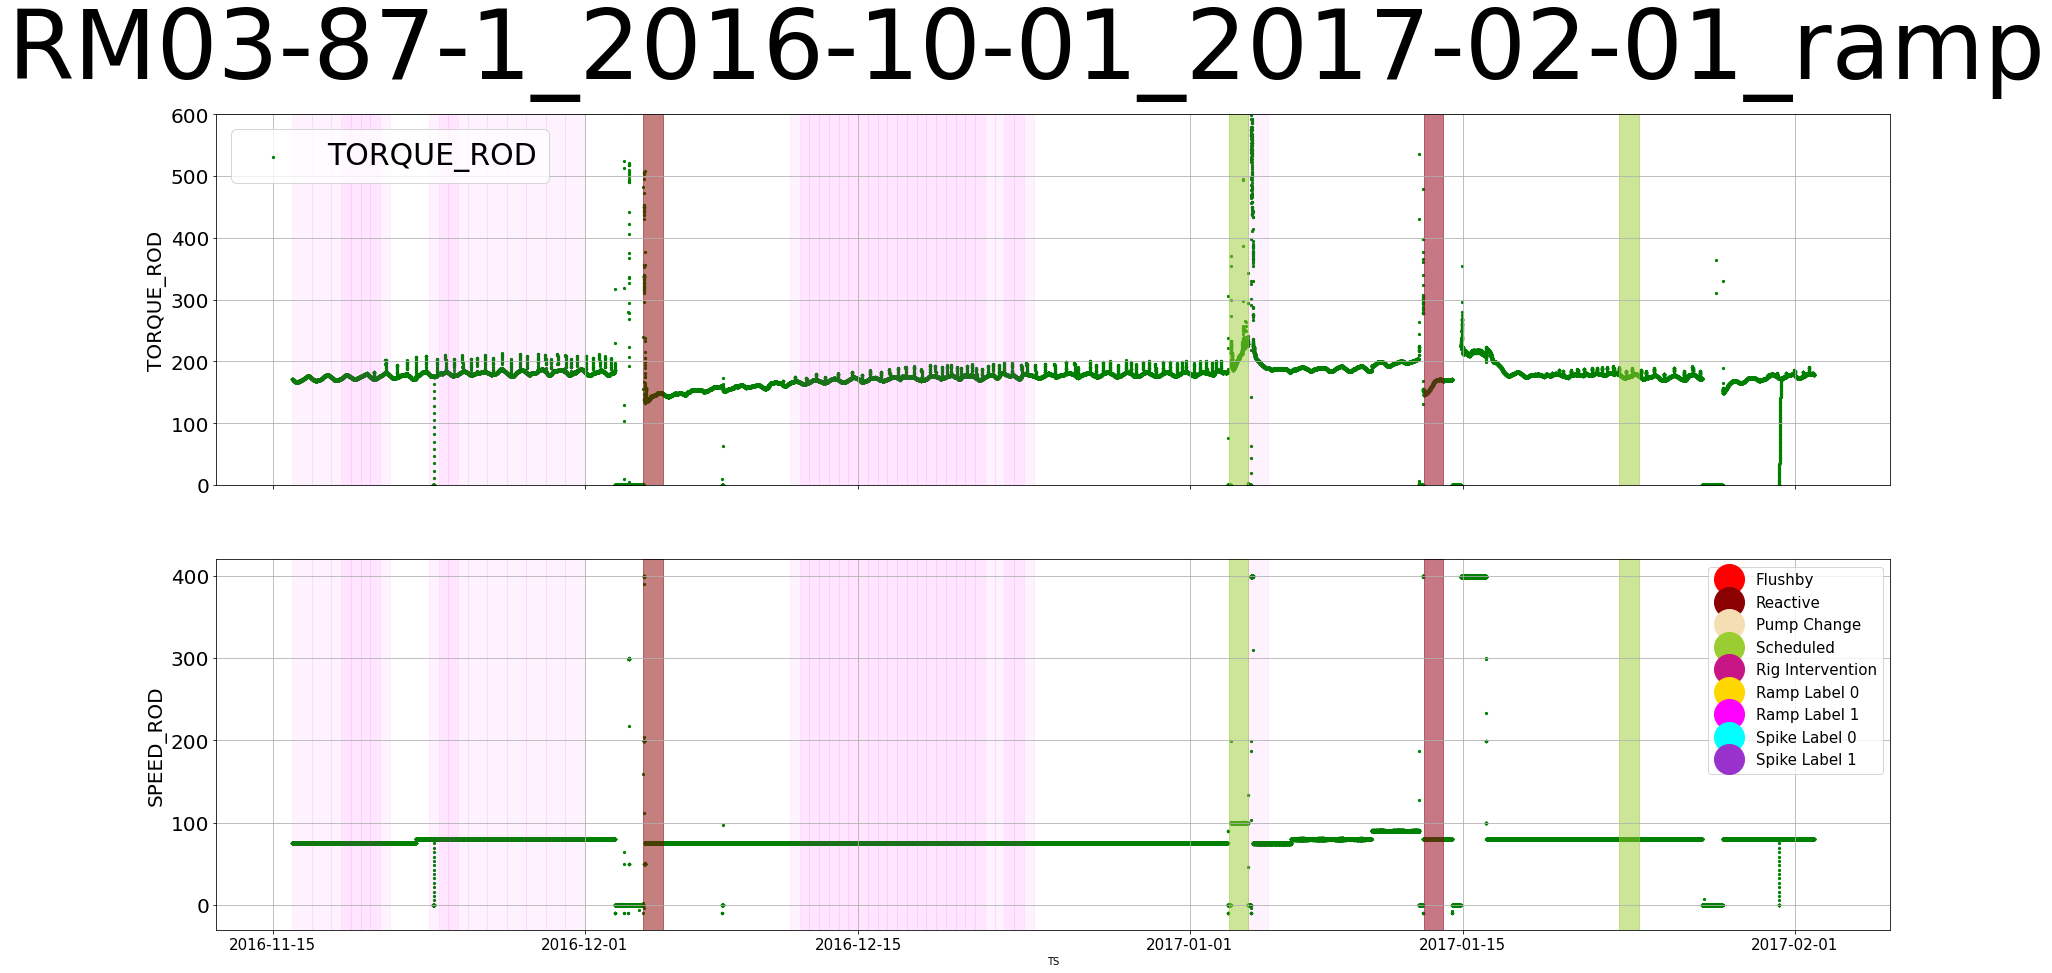

In [52]:
label_data = 'ramp'
start = '2016-10-01'
end = '2017-02-01'
save_name = f"{well_id}_{start}_{end}_{label_data}.png"

if label_data == 'ramp':
    ramp_label = ramp_df
    spike_label = None
if label_data == 'spike':
    ramp_label = None
    spike_label = spike_df
if label_data == 'both':
    ramp_label = ramp_df
    spike_label = spike_df 
    
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = ramp_label,
                  spike_label = None,
                  label_df=label,
                  start=start,
                  end=end,
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]},
                  save_name=save_name)

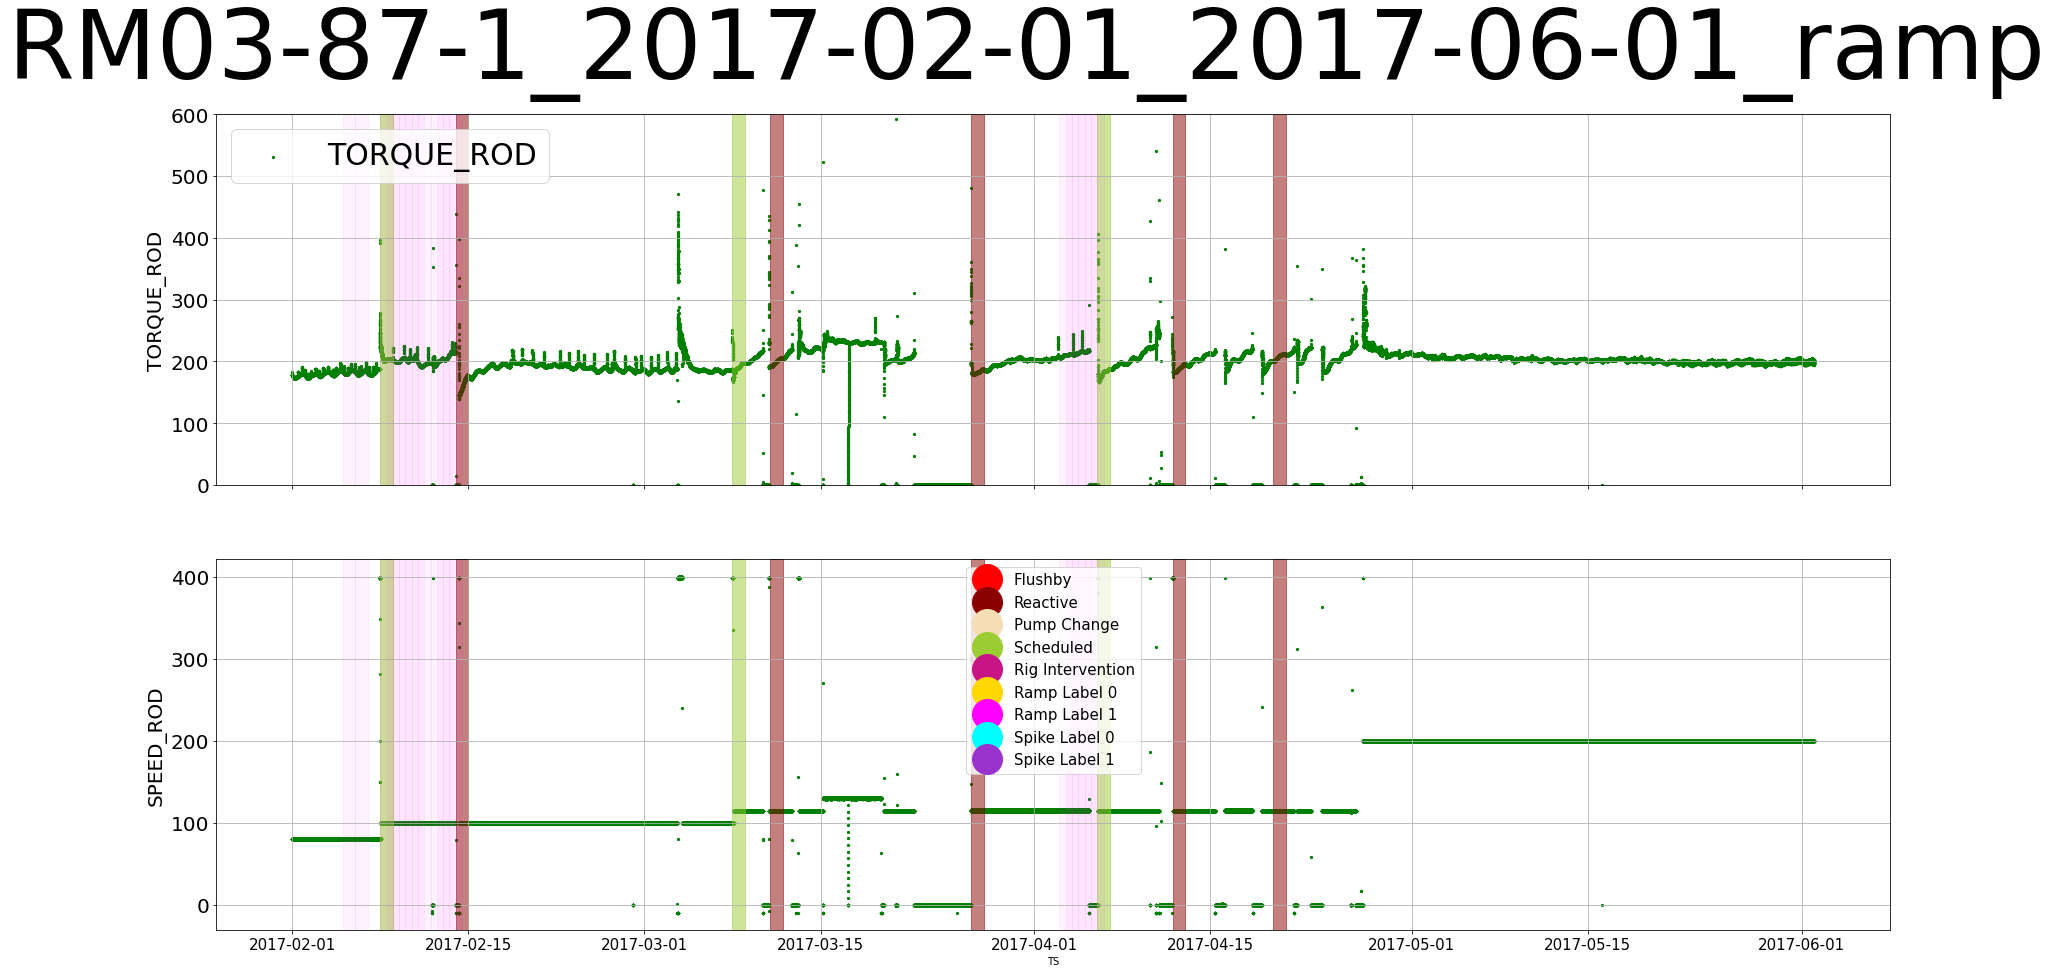

In [53]:
label_data = 'ramp'
start = '2017-02-01'
end = '2017-06-01'
save_name = f"{well_id}_{start}_{end}_{label_data}.png"

if label_data == 'ramp':
    ramp_label = ramp_df
    spike_label = None
if label_data == 'spike':
    ramp_label = None
    spike_label = spike_df
if label_data == 'both':
    ramp_label = ramp_df
    spike_label = spike_df 
    
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = ramp_label,
                  spike_label = None,
                  label_df=label,
                  start=start,
                  end=end,
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]},
                  save_name=save_name)

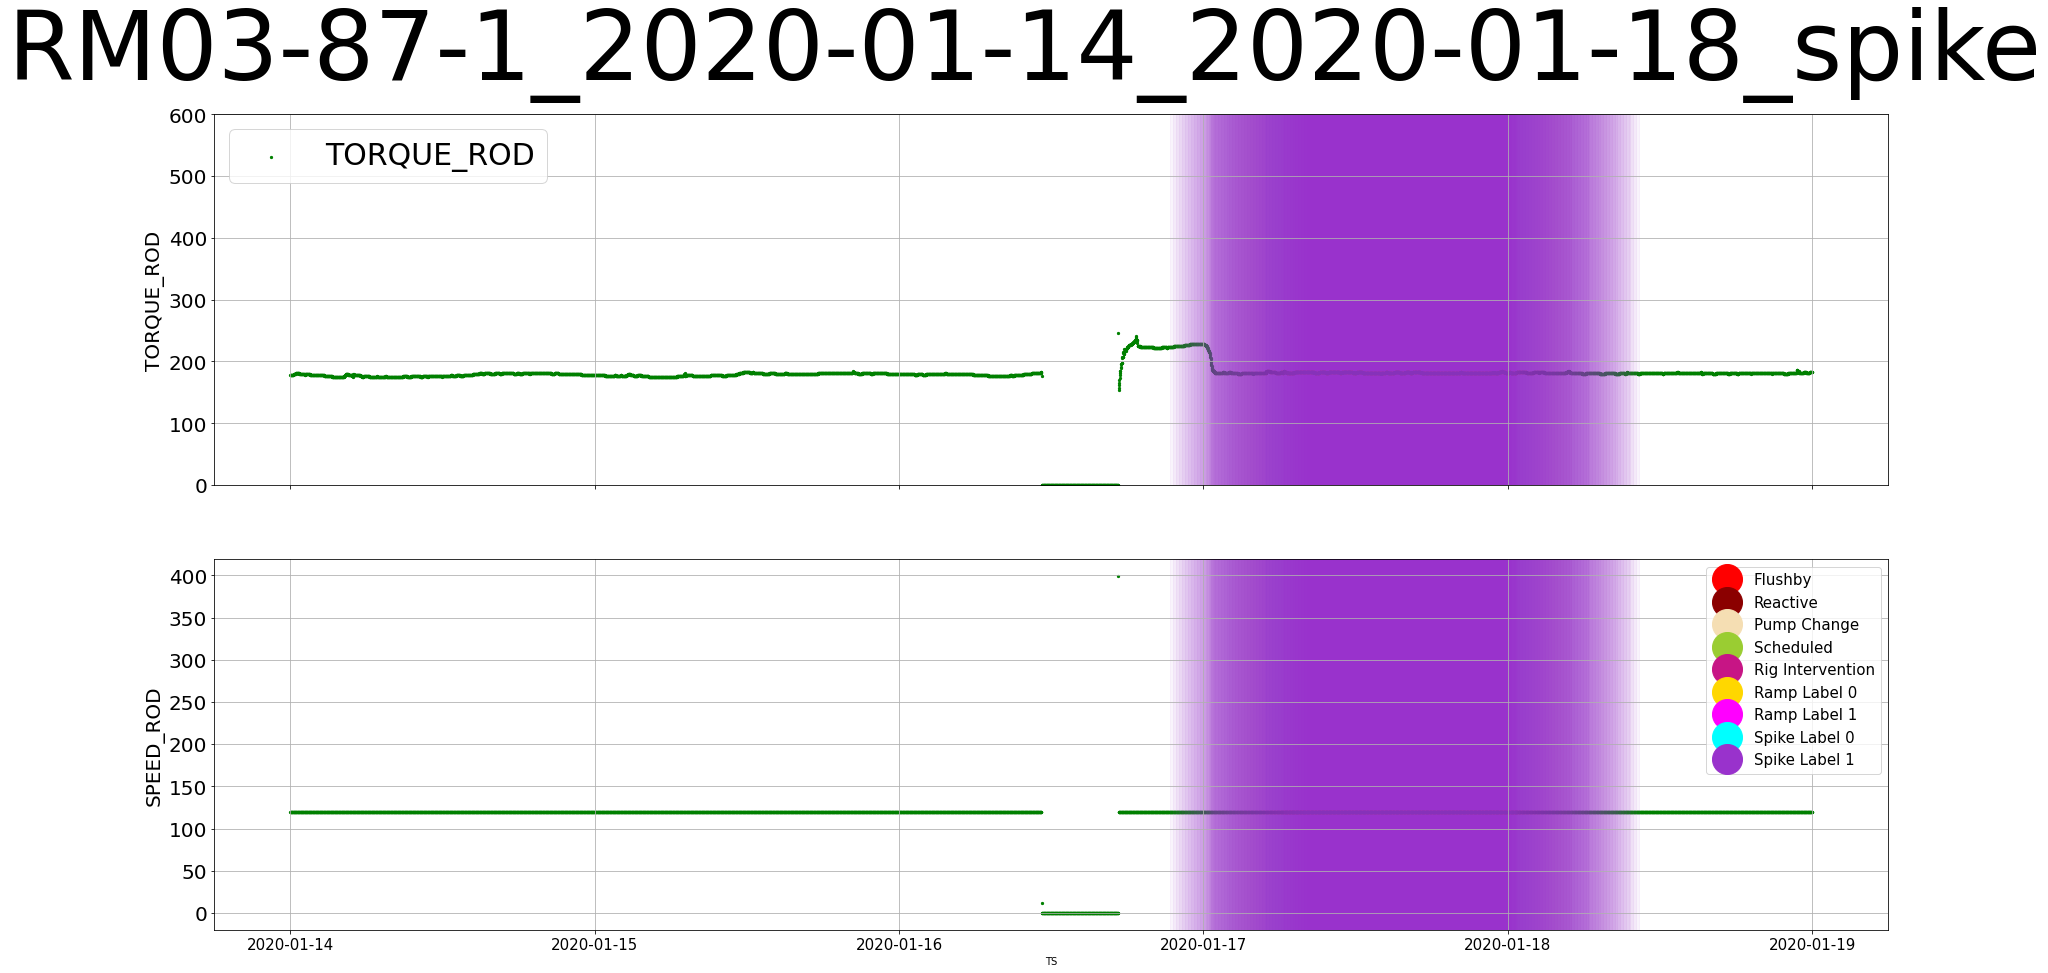

In [91]:
label_data = 'spike'
start = '2020-01-14'
end = '2020-01-18'
save_name = f"{well_id}_{start}_{end}_{label_data}.png"

if label_data == 'ramp':
    ramp_label = ramp_df
    spike_label = None
if label_data == 'spike':
    ramp_label = None
    spike_label = spike_df
if label_data == 'both':
    ramp_label = ramp_df
    spike_label = spike_df 
    
fig = plot_TORQUE(tag_df,
                  well_name=well_id,
                  ramp_label = ramp_label,
                  spike_label = spike_label,
                  label_df=label,
                  start=start,
                  end=end,
                  well_type='ROD',
                  ylim = {"TORQUE_ROD":[0, 600]},
                  save_name=save_name)

In [89]:
len(spike_df.loc[start:end])

67

,ramp_label
TS,


In [95]:
feat='TORQUE_ROD'
speed_feat='SPEED_ROD'
polynomial_days='7d'
polynomial_degree=4 
off_threshold=10
flush_diff_threshold=4.9
flush_std_threshold=4
spike_diff_threshold=0.021
diff_compare_window=60
ramp_integral_threshold=0.7


tag_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/data/{data_from_folder}/limited_tag_{well_id}.pkl')
tag_df=tag_df.asfreq('T', method='ffill')#.resample('1min').mean()#
tag_df=tag_df.interpolate(method='linear', axis=0)

########### Create well off and flush traces######################


#remove well off periods. This also removes an area four hours after the well was off. 
#This is because there is often a start up where the torque may spike when the well is turned back on and we do not wish to label this.
off_trace=pd.DataFrame(index=tag_df.index, columns=['off'])
off_times=tag_df[tag_df[feat]<off_threshold]
for point in off_times.index:
    off_trace['off'].loc[point-pd.Timedelta("30min"):point+pd.Timedelta("4H")]=1
print('off trace done')

#The flush trace is for excluding spikes in the torque that are due to flushes being performed.
#Additionally this excludes the times when the speed of the rod is changed. 
flush_trace=pd.DataFrame(index=tag_df.index, columns=['flush'])
flush_diff=tag_df[tag_df[speed_feat].diff(1).abs().rolling("2H").sum()>flush_diff_threshold]
flush_std=tag_df[tag_df[speed_feat].rolling("2H").std()>flush_std_threshold]
exlude_ind=flush_diff.index.intersection(flush_std.index)
for point in exlude_ind:
    flush_trace['flush'].loc[point-pd.Timedelta("30min"):point+pd.Timedelta("1H")]=1
print('flush trace done')


tag_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/data/{data_from_folder}/limited_tag_{well_id}.pkl')
tag_df=tag_df.asfreq('T', method='nearest')

tag_df.loc[off_trace['off']==1,[feat]]=np.nan
tag_df.loc[flush_trace['flush']==1,[feat]]=np.nan
tag_df=tag_df[~tag_df[feat].isna()]
peaks=tag_df[feat].rolling(120).std().diff(diff_compare_window)/tag_df[feat].rolling(120).mean()
peak_df=peaks.to_frame()
spike_label_df=pd.DataFrame(index=tag_df.index,columns=['spike_label'])
for peak in peaks[peaks>spike_diff_threshold].to_frame().index:
    spike_label_df.loc[peak-pd.Timedelta("1H"):peak,['spike_label']]=1
spike_label_df[spike_label_df.isna()]=0

off trace done
flush trace done
